In [1]:
# Install required libraries
import subprocess
import sys

packages = ['yfinance', 'pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'tensorflow', 'keras']
for package in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])

## Section 1: Import Required Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
import warnings
warnings.filterwarnings("ignore")

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

## Section 2: Load Predicted Commodity Prices

Load prices for all commodities directly from Yahoo Finance. We'll focus on the predicted prices extracted from the individual prediction notebooks.

In [2]:
# Load historical data for commodities (we'll use the last year to train the basket)
commodities = {
    'SILVER': 'SI=F',      # COMEX Silver Futures
    'GOLD': 'GC=F',        # COMEX Gold Futures
    'COPPER': 'HG=F',      # COMEX Copper Futures
    'CORN': 'ZC=F',        # CBOT Corn Futures
    'WHEAT': 'ZW=F',       # CBOT Wheat Futures
    'SOYBEAN': 'ZS=F',     # CBOT Soybean Futures
    'LITHIUM': 'LIT',      # Global X Lithium & Battery Tech ETF (proxy for lithium)
    'RARE_EARTH': 'REE',   # Rare Element Resources Ltd (proxy for rare earth metals)
    'NATURAL_GAS': 'NG=F'  # NYMEX Natural Gas Futures
}

# Download data
df_prices = pd.DataFrame()
print("Downloading commodity price data...")
for commodity_name, ticker in commodities.items():
    try:
        data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)
        df_prices[commodity_name] = data['Close']
        print(f"✓ {commodity_name} ({ticker}) loaded successfully")
    except Exception as e:
        print(f"✗ Error loading {commodity_name} ({ticker}): {str(e)}")

df_prices = df_prices.dropna()
print(f"\nData shape: {df_prices.shape}")
print(f"Date range: {df_prices.index[0].date()} to {df_prices.index[-1].date()}")
print("\nFirst few rows:")
print(df_prices.head())

✓ SILVER (SI=F) loaded successfully
✓ GOLD (GC=F) loaded successfully
✓ COPPER (HG=F) loaded successfully
✓ CORN (ZC=F) loaded successfully
✓ WHEAT (ZW=F) loaded successfully
✓ SOYBEAN (ZS=F) loaded successfully
✓ LITHIUM (LIT) loaded successfully
✓ RARE_EARTH (REE) loaded successfully
✓ NATURAL_GAS (NG=F) loaded successfully

Data shape: (998, 9)
Date range: 2021-01-13 to 2024-12-31

First few rows:
               SILVER         GOLD  COPPER    CORN   WHEAT  SOYBEAN  \
Date                                                                  
2021-01-13  25.520000  1853.599976  3.6170  524.50  660.50  1411.00   
2021-01-14  25.746000  1850.300049  3.6680  534.25  670.00  1436.50   
2021-01-15  24.825001  1829.300049  3.6030  531.50  675.50  1416.75   
2021-01-19  25.278999  1839.500000  3.6360  526.00  672.25  1385.75   
2021-01-20  25.733999  1865.900024  3.6475  522.00  667.75  1369.50   

              LITHIUM  RARE_EARTH  NATURAL_GAS  
Date                                            


## Section 3: Calculate Pairwise Correlation Matrix

Compute correlations between silver and all other commodities to identify hedging opportunities.

SILVER CORRELATIONS WITH OTHER COMMODITIES
GOLD           0.807841
COPPER         0.565632
RARE_EARTH     0.089811
WHEAT         -0.449785
CORN          -0.525751
LITHIUM       -0.539012
NATURAL_GAS   -0.553844
SOYBEAN       -0.580689
Name: SILVER, dtype: float64

Positively correlated (Hedging with these reduces variance):
  GOLD           : +0.8078
  COPPER         : +0.5656
  RARE_EARTH     : +0.0898

Negatively correlated (Hedging with these provides offset):
  WHEAT          : -0.4498
  CORN           : -0.5258
  LITHIUM        : -0.5390
  NATURAL_GAS    : -0.5538
  SOYBEAN        : -0.5807


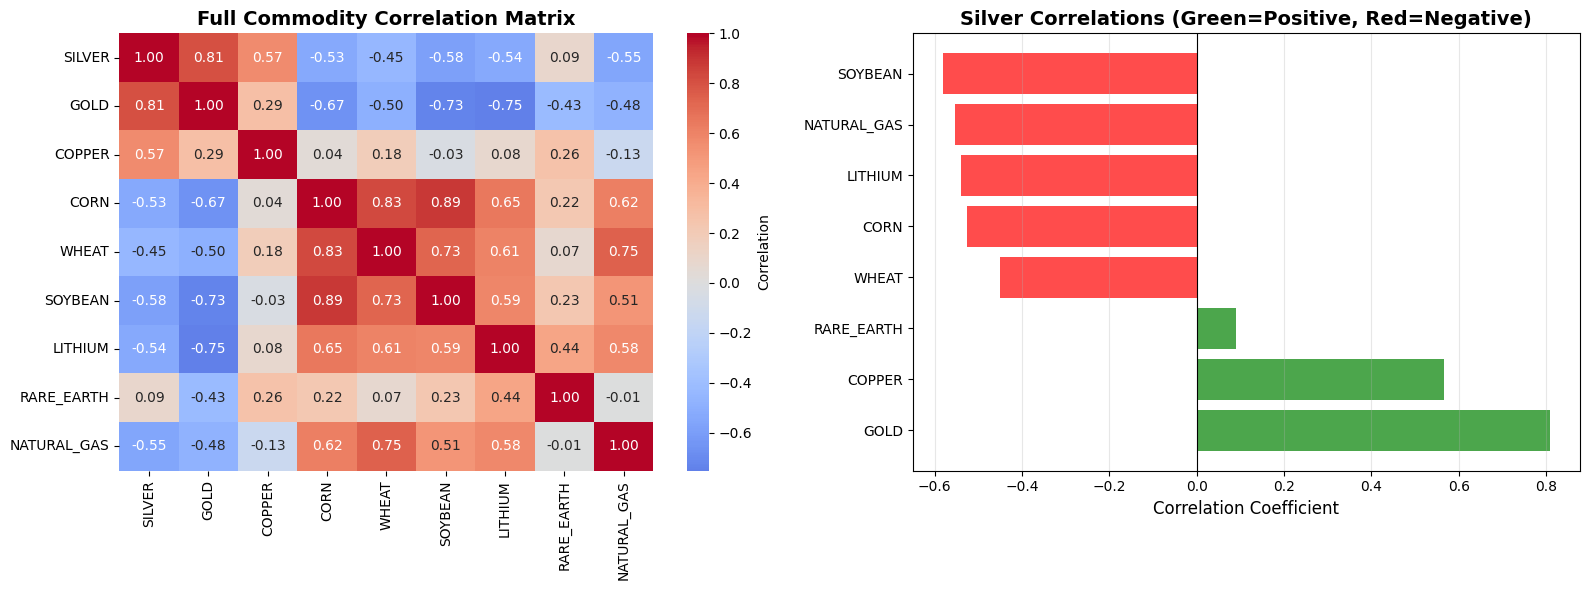

In [3]:
# Calculate correlation matrix
correlation_matrix = df_prices.corr()

# Extract silver correlations
silver_correlations = correlation_matrix['SILVER'].drop('SILVER').sort_values(ascending=False)

print("=" * 60)
print("SILVER CORRELATIONS WITH OTHER COMMODITIES")
print("=" * 60)
print(silver_correlations)
print("\nPositively correlated (Hedging with these reduces variance):")
for commodity, corr in silver_correlations[silver_correlations > 0].items():
    print(f"  {commodity:15s}: {corr:+.4f}")

print("\nNegatively correlated (Hedging with these provides offset):")
for commodity, corr in silver_correlations[silver_correlations < 0].items():
    print(f"  {commodity:15s}: {corr:+.4f}")

# Plot correlation heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Full correlation matrix heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            cbar_kws={'label': 'Correlation'}, ax=axes[0])
axes[0].set_title('Full Commodity Correlation Matrix', fontsize=14, fontweight='bold')

# Silver correlations bar plot
colors = ['green' if x > 0 else 'red' for x in silver_correlations.values]
axes[1].barh(range(len(silver_correlations)), silver_correlations.values, color=colors, alpha=0.7)
axes[1].set_yticks(range(len(silver_correlations)))
axes[1].set_yticklabels(silver_correlations.index)
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_xlabel('Correlation Coefficient', fontsize=12)
axes[1].set_title('Silver Correlations (Green=Positive, Red=Negative)', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)

## Section 4: Prepare Data for Neural Network

Create feature matrix (X) with all commodities except silver, and target vector (y) with silver prices. Normalize data for training.

In [5]:
# Prepare data for neural network
commodities_list = [col for col in df_prices.columns if col != 'SILVER']
X = df_prices[commodities_list].values
y = df_prices['SILVER'].values.reshape(-1, 1)

print(f"Feature matrix shape (X): {X.shape}")
print(f"Target vector shape (y): {y.shape}")
print(f"Commodities used as features: {commodities_list}")

# Standardize features for better neural network training
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Split data into train and test sets (80/20)
split_idx = int(0.8 * len(X))
X_train = X_scaled[:split_idx]
X_test = X_scaled[split_idx:]
y_train = y_scaled[:split_idx]
y_test = y_scaled[split_idx:]

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"\nData preparation complete!")

Feature matrix shape (X): (998, 8)
Target vector shape (y): (998, 1)
Commodities used as features: ['GOLD', 'COPPER', 'CORN', 'WHEAT', 'SOYBEAN', 'LITHIUM', 'RARE_EARTH', 'NATURAL_GAS']

Training set size: 798 samples
Test set size: 200 samples

Data preparation complete!


## Section 5: Train Neural Network Model

Build and train a neural network to learn the optimal weights that map commodity prices to silver prices.


Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)


Training the model...
Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6802 - mae: 0.6201 - val_loss: 0.0884 - val_mae: 0.2523
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2971 - mae: 0.4218 - val_loss: 0.0599 - val_mae: 0.1976
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2026 - mae: 0.3539 - val_loss: 0.0778 - val_mae: 0.2235
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1789 - mae: 0.3348 - val_loss: 0.0849 - val_mae: 0.2380
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1807 - mae: 0.3309 - val_loss: 0.0896 - val_mae: 0.2487
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1553 - mae: 0.3039 - val_loss: 0.0808 - val_mae: 0.2354
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1493 - mae: 0.2998 - val_loss: 0.0784 - val_mae: 0.2324
Epoch 8/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1397 - mae: 0.2936 - val_loss: 0.0793 - val_mae: 0.2329
Epoch 9/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0

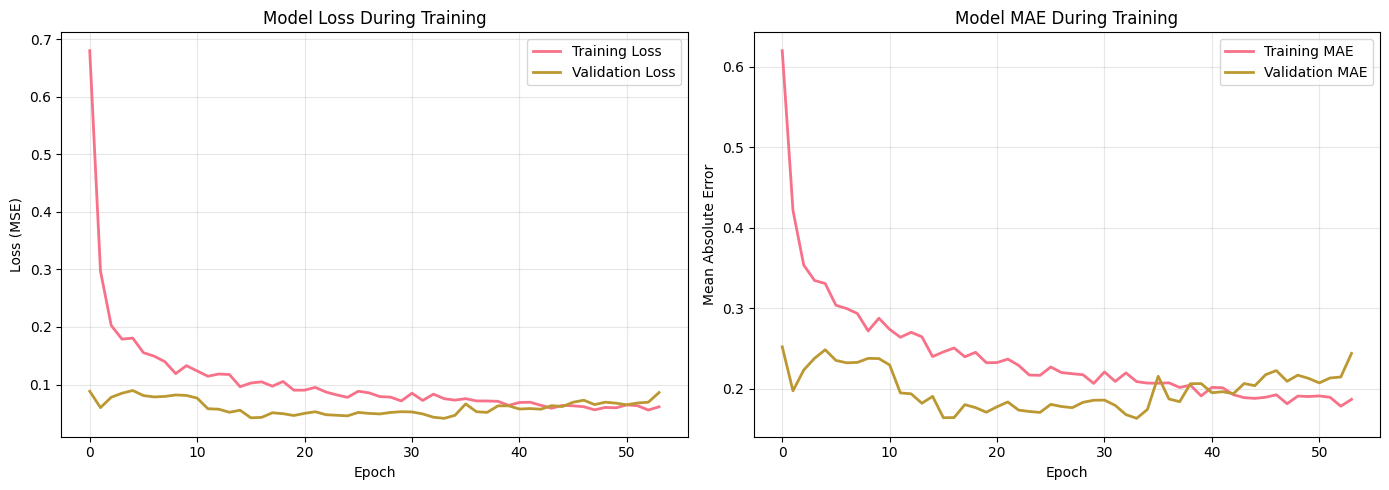

In [6]:
# Build neural network model for commodity weighting
import tensorflow as tf
from keras import backend as K
import gc

# Clear any previous models and garbage collect
if 'model' in locals():
    del model
    gc.collect()

K.clear_session()
tf.compat.v1.reset_default_graph()

# Build model with a fresh start
model = Sequential([
    Dense(64, activation='relu', input_shape=(len(commodities_list),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(1)  # Single output (silver price)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("Neural Network Architecture:")
print("=" * 60)
model.summary()
print("=" * 60)

# Add early stopping to prevent overfitting
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Train the model
print("\nTraining the model...")
history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss (MSE): {test_loss:.6f}")
print(f"Test MAE: {test_mae:.6f}")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Model Loss During Training')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].set_title('Model MAE During Training')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## Section 6: Extract Commodity Weights

Extract the learned weights from the neural network's first layer to determine each commodity's contribution to the basket.

NEURAL NETWORK LEARNED COMMODITY WEIGHTS
     Commodity  Raw_Weight  Normalized_Weight  Correlation_with_Silver
3        WHEAT   -0.020144          -0.233346                -0.449785
5      LITHIUM    0.018640           0.215922                -0.539012
0         GOLD    0.010009           0.115936                 0.807841
7  NATURAL_GAS   -0.009563          -0.110771                -0.553844
2         CORN   -0.009418          -0.109092                -0.525751
1       COPPER    0.008816           0.102123                 0.565632
6   RARE_EARTH    0.006454           0.074759                 0.089811
4      SOYBEAN   -0.003285          -0.038051                -0.580689

Note: Positive weights indicate commodities to INCLUDE in the basket
      Negative weights indicate commodities to USE for HEDGING (inverse relationship)


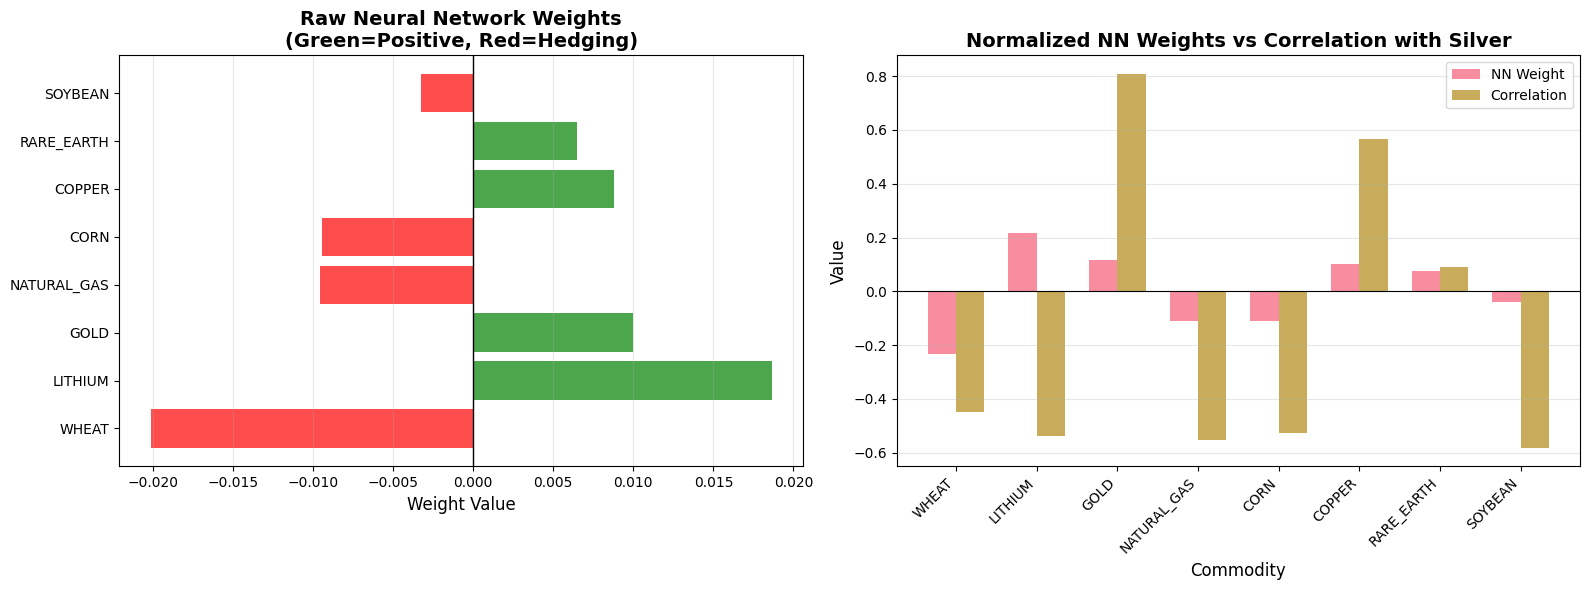

In [7]:
# Extract weights from the first layer of the neural network
# Get all layers with weights
layers_with_weights = [layer for layer in model.layers if layer.get_weights()]
first_layer_weights = layers_with_weights[0].get_weights()[0]  # Get weight matrix from first layer

# Average the weights from first layer (averaging across the 64 neurons)
commodity_weights = np.mean(first_layer_weights, axis=1)

# Normalize weights to sum to 1 (for basket construction)
commodity_weights_normalized = commodity_weights / np.sum(np.abs(commodity_weights))

# Create a weights dataframe for visualization
weights_df = pd.DataFrame({
    'Commodity': commodities_list,
    'Raw_Weight': commodity_weights,
    'Normalized_Weight': commodity_weights_normalized,
    'Correlation_with_Silver': [silver_correlations[c] for c in commodities_list]
})

# Sort by absolute normalized weight
weights_df['Abs_Weight'] = np.abs(weights_df['Normalized_Weight'])
weights_df = weights_df.sort_values('Abs_Weight', ascending=False)

print("=" * 80)
print("NEURAL NETWORK LEARNED COMMODITY WEIGHTS")
print("=" * 80)
print(weights_df[['Commodity', 'Raw_Weight', 'Normalized_Weight', 'Correlation_with_Silver']])
print("\nNote: Positive weights indicate commodities to INCLUDE in the basket")
print("      Negative weights indicate commodities to USE for HEDGING (inverse relationship)")
print("=" * 80)

# Visualize weights
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw weights
colors = ['green' if w > 0 else 'red' for w in weights_df['Raw_Weight']]
axes[0].barh(weights_df['Commodity'], weights_df['Raw_Weight'], color=colors, alpha=0.7)
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[0].set_xlabel('Weight Value', fontsize=12)
axes[0].set_title('Raw Neural Network Weights\n(Green=Positive, Red=Hedging)', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Normalized weights vs correlation
x = np.arange(len(weights_df))
width = 0.35
axes[1].bar(x - width/2, weights_df['Normalized_Weight'], width, label='NN Weight', alpha=0.8)
axes[1].bar(x + width/2, weights_df['Correlation_with_Silver'], width, label='Correlation', alpha=0.8)
axes[1].set_ylabel('Value', fontsize=12)
axes[1].set_xlabel('Commodity', fontsize=12)
axes[1].set_title('Normalized NN Weights vs Correlation with Silver', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(weights_df['Commodity'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)

plt.tight_layout()
plt.show()

## Section 7: Generate Basket Prices

Calculate predicted basket prices by applying the learned neural network weights to commodity prices.


BASKET COMPOSITION BY PERCENTAGE

Commodity Composition (by absolute weight percentage):

↓ SHORT | WHEAT           |  23.33% | ███████████
↑ LONG  | LITHIUM         |  21.59% | ██████████
↑ LONG  | GOLD            |  11.59% | █████
↓ SHORT | NATURAL_GAS     |  11.08% | █████
↓ SHORT | CORN            |  10.91% | █████
↑ LONG  | COPPER          |  10.21% | █████
↑ LONG  | RARE_EARTH      |   7.48% | ███
↓ SHORT | SOYBEAN         |   3.81% | █

--------------------------------------------------------------------------------
Summary Statistics:
--------------------------------------------------------------------------------

Total LONG (Positive) Allocation: 50.87%
  Commodities in basket: LITHIUM, GOLD, COPPER, RARE_EARTH

Total SHORT (Hedging) Allocation: 49.13%
  Commodities for hedging: WHEAT, NATURAL_GAS, CORN, SOYBEAN



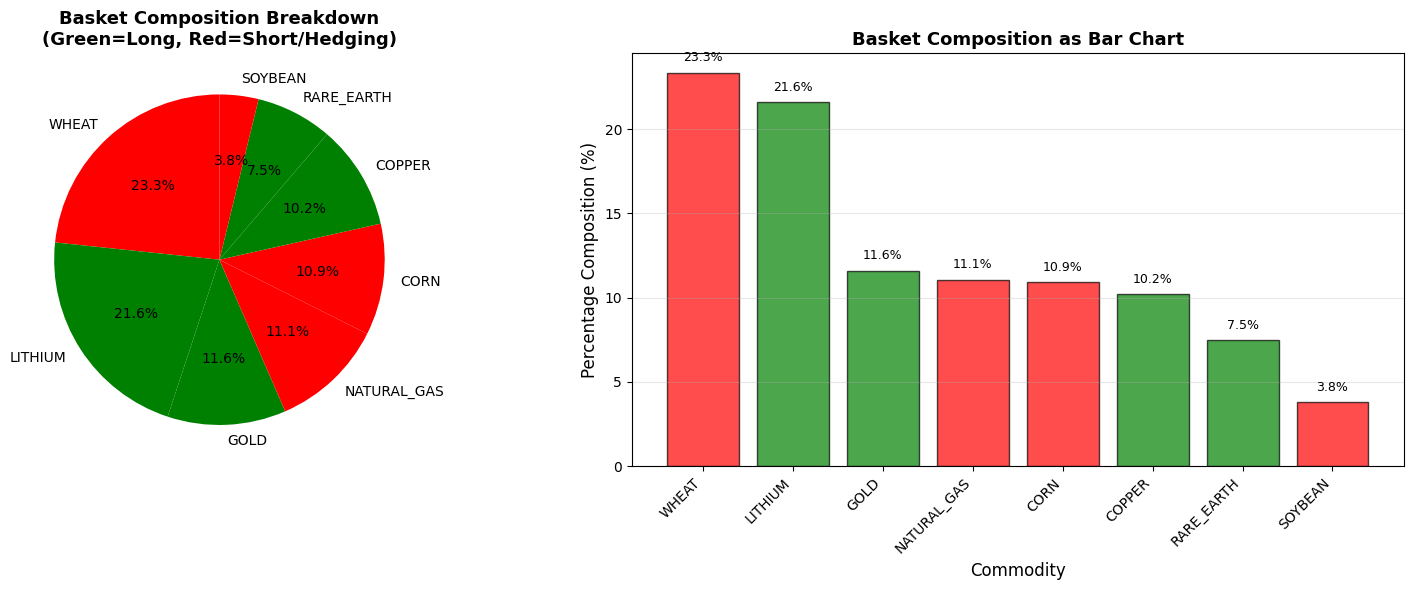

In [8]:
# Calculate and display percentage composition of the basket
print("\n" + "=" * 80)
print("BASKET COMPOSITION BY PERCENTAGE")
print("=" * 80)

# Calculate absolute weights for percentage calculation
abs_weights = np.abs(weights_df['Normalized_Weight'].values)
weight_percentages = (abs_weights / abs_weights.sum()) * 100

# Create composition dataframe
composition_df = weights_df.copy()
composition_df['Percentage_Composition'] = weight_percentages
composition_df = composition_df.sort_values('Percentage_Composition', ascending=False)

print("\nCommodity Composition (by absolute weight percentage):\n")
for idx, row in composition_df.iterrows():
    sign = "↑ LONG " if row['Normalized_Weight'] > 0 else "↓ SHORT"
    bar_length = int(row['Percentage_Composition'] / 2)
    bar = "█" * bar_length
    print(f"{sign} | {row['Commodity']:15s} | {row['Percentage_Composition']:6.2f}% | {bar}")

print("\n" + "-" * 80)
print("Summary Statistics:")
print("-" * 80)

# Long positions (positive weights)
long_positions = composition_df[composition_df['Normalized_Weight'] > 0]
long_percentage = long_positions['Percentage_Composition'].sum()

# Short positions (negative weights)
short_positions = composition_df[composition_df['Normalized_Weight'] < 0]
short_percentage = short_positions['Percentage_Composition'].sum()

print(f"\nTotal LONG (Positive) Allocation: {long_percentage:.2f}%")
print(f"  Commodities in basket: {', '.join(long_positions['Commodity'].values)}")

print(f"\nTotal SHORT (Hedging) Allocation: {short_percentage:.2f}%")
if len(short_positions) > 0:
    print(f"  Commodities for hedging: {', '.join(short_positions['Commodity'].values)}")
else:
    print(f"  Commodities for hedging: None")

print("\n" + "=" * 80)

# Visualize composition as pie chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart of all commodities
colors_list = ['green' if w > 0 else 'red' for w in composition_df['Normalized_Weight']]
axes[0].pie(composition_df['Percentage_Composition'], 
            labels=composition_df['Commodity'],
            autopct='%1.1f%%',
            colors=colors_list,
            startangle=90,
            textprops={'fontsize': 10})
axes[0].set_title('Basket Composition Breakdown\n(Green=Long, Red=Short/Hedging)', 
                  fontsize=13, fontweight='bold')

# Bar chart comparison
x_pos = np.arange(len(composition_df))
bars = axes[1].bar(x_pos, composition_df['Percentage_Composition'], color=colors_list, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Commodity', fontsize=12)
axes[1].set_ylabel('Percentage Composition (%)', fontsize=12)
axes[1].set_title('Basket Composition as Bar Chart', fontsize=13, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(composition_df['Commodity'], rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, composition_df['Percentage_Composition'])):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{val:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [9]:
# Generate predictions on the full dataset
y_pred_scaled = model.predict(X_scaled, verbose=0)

# Inverse transform to get predictions in original scale
y_pred_original = scaler_y.inverse_transform(y_pred_scaled)
y_actual_original = scaler_y.inverse_transform(y_scaled)

# Create basket using learned weights from input features directly
# Method 1: Using normalized weights on original price data
basket_prices_method1 = np.dot(X, commodity_weights_normalized)

# Method 2: Using normalized weights applied to scaled data
basket_prices_method2 = np.dot(X_scaled, commodity_weights_normalized)
basket_prices_method2_original = (basket_prices_method2 - basket_prices_method2.mean()) / basket_prices_method2.std() * y.std() + y.mean()

# Use Method 1 for simplicity - normalize to silver's scale for comparison
basket_prices_normalized = (basket_prices_method1 - basket_prices_method1.mean()) / basket_prices_method1.std() * y.std() + y.mean()

# Create results dataframe
results_df = pd.DataFrame({
    'Date': df_prices.index,
    'Silver_Actual': y.flatten(),
    'Silver_Predicted': y_pred_original.flatten(),
    'Basket_Price': basket_prices_normalized.flatten()
})

print("=" * 80)
print("PREDICTION AND BASKET PRICE RESULTS")
print("=" * 80)
print(f"Silver Actual - Mean: ${results_df['Silver_Actual'].mean():.2f}, Std: ${results_df['Silver_Actual'].std():.2f}")
print(f"Silver Predicted - Mean: ${results_df['Silver_Predicted'].mean():.2f}, Std: ${results_df['Silver_Predicted'].std():.2f}")
print(f"Basket Price - Mean: ${results_df['Basket_Price'].mean():.2f}, Std: ${results_df['Basket_Price'].std():.2f}")

# Calculate model performance metrics
r2_nn = r2_score(y_actual_original, y_pred_original)
rmse_nn = np.sqrt(mean_squared_error(y_actual_original, y_pred_original))
mae_nn = mean_absolute_error(y_actual_original, y_pred_original)

print("\n" + "-" * 80)
print("NEURAL NETWORK MODEL PERFORMANCE")
print("-" * 80)
print(f"R² Score: {r2_nn:.4f}")
print(f"RMSE: ${rmse_nn:.4f}")
print(f"MAE: ${mae_nn:.4f}")

# Calculate basket vs actual correlation
basket_silver_corr = results_df['Basket_Price'].corr(results_df['Silver_Actual'])
print(f"\nBasket-Silver Correlation: {basket_silver_corr:.4f}")
print("=" * 80)

print("\nFirst 10 rows of predictions:")
print(results_df.head(10))

PREDICTION AND BASKET PRICE RESULTS
Silver Actual - Mean: $24.64, Std: $3.33
Silver Predicted - Mean: $24.08, Std: $2.07
Basket Price - Mean: $24.64, Std: $3.33

--------------------------------------------------------------------------------
NEURAL NETWORK MODEL PERFORMANCE
--------------------------------------------------------------------------------
R² Score: 0.7526
RMSE: $1.6533
MAE: $1.0404

Basket-Silver Correlation: 0.7186

First 10 rows of predictions:
        Date  Silver_Actual  Silver_Predicted  Basket_Price
0 2021-01-13      25.520000         25.409985     25.420322
1 2021-01-14      25.746000         25.593170     25.212676
2 2021-01-15      24.825001         25.276127     25.075181
3 2021-01-19      25.278999         25.362740     25.274153
4 2021-01-20      25.733999         25.510792     25.528831
5 2021-01-21      25.822001         25.602921     25.612540
6 2021-01-22      25.524000         25.495525     26.064801
7 2021-01-25      25.455000         25.503269     25.

## Section 8: Visualize Silver vs Basket Prices

Compare predicted silver prices with the weighted commodity basket to evaluate hedging effectiveness.

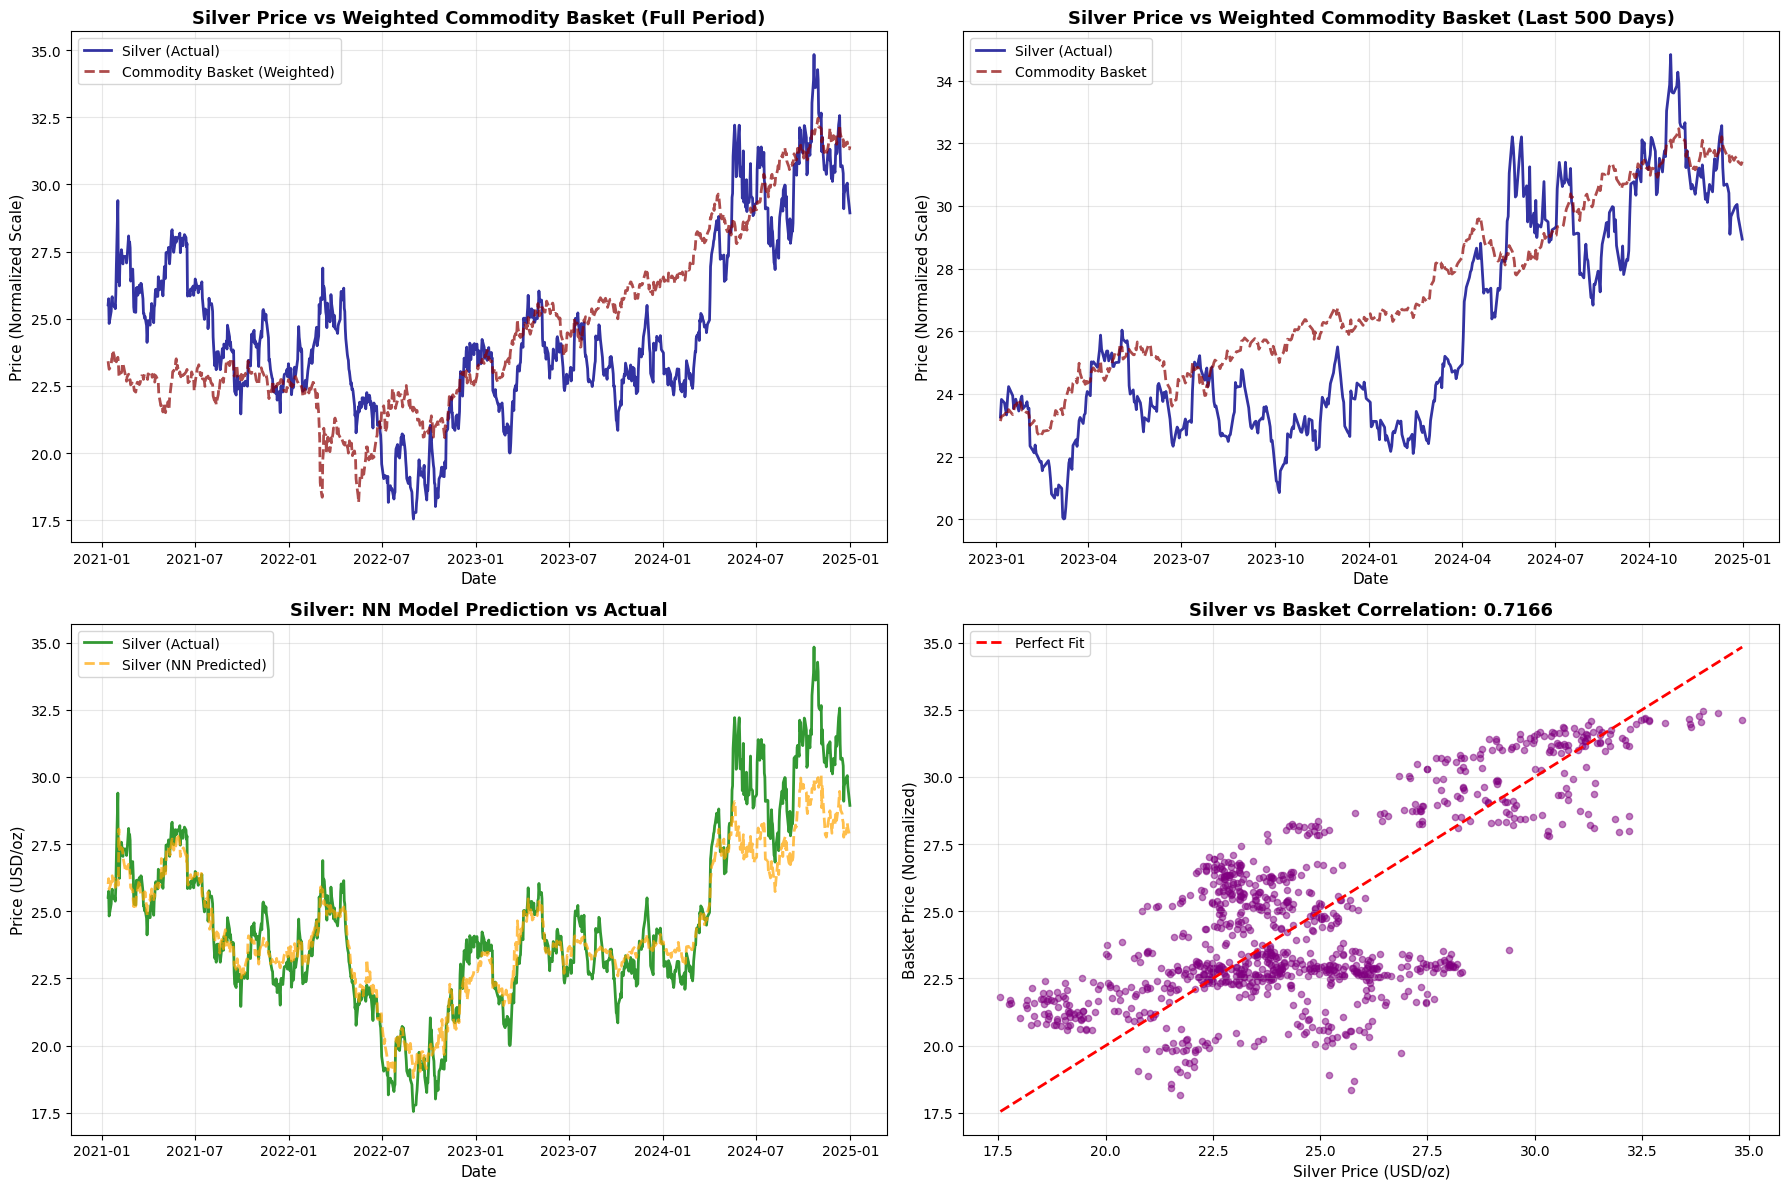

Plots generated successfully!


In [11]:
# Main plot: Silver vs Basket
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Full time series
axes[0, 0].plot(results_df['Date'], results_df['Silver_Actual'], label='Silver (Actual)', color='darkblue', linewidth=2, alpha=0.8)
axes[0, 0].plot(results_df['Date'], results_df['Basket_Price'], label='Commodity Basket (Weighted)', color='darkred', linewidth=2, alpha=0.7, linestyle='--')
axes[0, 0].set_xlabel('Date', fontsize=11)
axes[0, 0].set_ylabel('Price (Normalized Scale)', fontsize=11)
axes[0, 0].set_title('Silver Price vs Weighted Commodity Basket (Full Period)', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)

# Plot 2: Recent 500 days zoomed in
recent_data = results_df.tail(500)
axes[0, 1].plot(recent_data['Date'], recent_data['Silver_Actual'], label='Silver (Actual)', color='darkblue', linewidth=2, alpha=0.8)
axes[0, 1].plot(recent_data['Date'], recent_data['Basket_Price'], label='Commodity Basket', color='darkred', linewidth=2, alpha=0.7, linestyle='--')
axes[0, 1].set_xlabel('Date', fontsize=11)
axes[0, 1].set_ylabel('Price (Normalized Scale)', fontsize=11)
axes[0, 1].set_title('Silver Price vs Weighted Commodity Basket (Last 500 Days)', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3)

# Plot 3: NN Predicted vs Actual Silver
axes[1, 0].plot(results_df['Date'], results_df['Silver_Actual'], label='Silver (Actual)', color='green', linewidth=2, alpha=0.8)
axes[1, 0].plot(results_df['Date'], results_df['Silver_Predicted'], label='Silver (NN Predicted)', color='orange', linewidth=2, alpha=0.7, linestyle='--')
axes[1, 0].set_xlabel('Date', fontsize=11)
axes[1, 0].set_ylabel('Price (USD/oz)', fontsize=11)
axes[1, 0].set_title('Silver: NN Model Prediction vs Actual', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(alpha=0.3)

# Plot 4: Scatter plot - Silver vs Basket
axes[1, 1].scatter(results_df['Silver_Actual'], results_df['Basket_Price'], alpha=0.5, s=20, color='purple')
# Add reference line
min_val = min(results_df['Silver_Actual'].min(), results_df['Basket_Price'].min())
max_val = max(results_df['Silver_Actual'].max(), results_df['Basket_Price'].max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit')
axes[1, 1].set_xlabel('Silver Price (USD/oz)', fontsize=11)
axes[1, 1].set_ylabel('Basket Price (Normalized)', fontsize=11)
axes[1, 1].set_title(f'Silver vs Basket Correlation: {basket_silver_corr:.4f}', fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Plots generated successfully!")

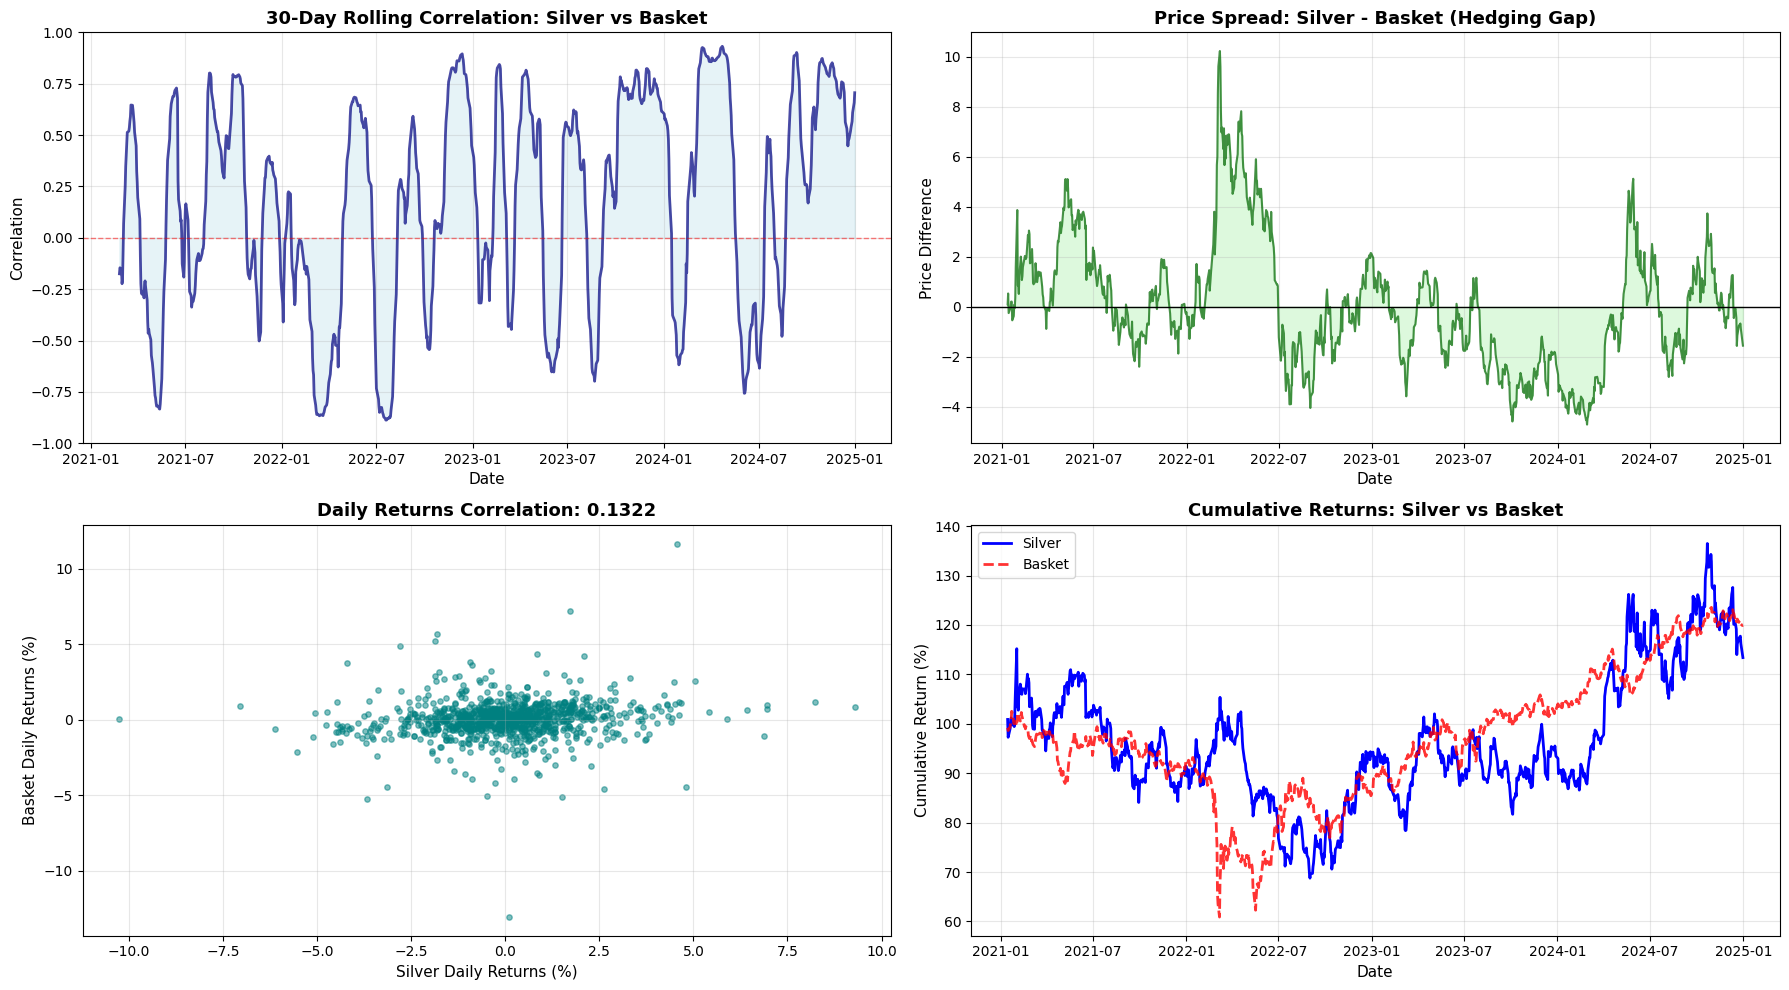


HEDGING AND PERFORMANCE ANALYSIS

Silver vs Basket Statistics:
  Overall Correlation: 0.7186
  Daily Returns Correlation: 0.1322
  Average Price Spread (Silver - Basket): $-0.00
  Std Dev of Price Spread: $2.49

Volatility Metrics:
  Silver Volatility (Std Dev): 1.8676%
  Basket Volatility (Std Dev): 1.2742%
  Volatility Reduction: 31.77%


In [10]:
# Additional analysis: Rolling correlation and performance
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Plot 1: Rolling 30-day correlation between basket and silver
rolling_corr = results_df['Silver_Actual'].rolling(30).corr(results_df['Basket_Price'])
axes[0, 0].plot(results_df['Date'], rolling_corr, color='navy', linewidth=2, alpha=0.7)
axes[0, 0].fill_between(results_df['Date'], rolling_corr, alpha=0.3, color='lightblue')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 0].set_xlabel('Date', fontsize=11)
axes[0, 0].set_ylabel('Correlation', fontsize=11)
axes[0, 0].set_title('30-Day Rolling Correlation: Silver vs Basket', fontsize=13, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_ylim([-1, 1])

# Plot 2: Rolling price difference (Silver - Basket)
price_diff = results_df['Silver_Actual'] - results_df['Basket_Price']
axes[0, 1].plot(results_df['Date'], price_diff, color='darkgreen', linewidth=1.5, alpha=0.7)
axes[0, 1].fill_between(results_df['Date'], price_diff, alpha=0.3, color='lightgreen')
axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[0, 1].set_xlabel('Date', fontsize=11)
axes[0, 1].set_ylabel('Price Difference', fontsize=11)
axes[0, 1].set_title('Price Spread: Silver - Basket (Hedging Gap)', fontsize=13, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Daily returns correlation
silver_returns = results_df['Silver_Actual'].pct_change()
basket_returns = results_df['Basket_Price'].pct_change()
returns_corr = silver_returns.corr(basket_returns)

axes[1, 0].scatter(silver_returns * 100, basket_returns * 100, alpha=0.5, s=15, color='teal')
axes[1, 0].set_xlabel('Silver Daily Returns (%)', fontsize=11)
axes[1, 0].set_ylabel('Basket Daily Returns (%)', fontsize=11)
axes[1, 0].set_title(f'Daily Returns Correlation: {returns_corr:.4f}', fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Plot 4: Cumulative performance comparison
cumulative_silver_ret = (1 + silver_returns).cumprod()
cumulative_basket_ret = (1 + basket_returns).cumprod()

axes[1, 1].plot(results_df['Date'], cumulative_silver_ret * 100, label='Silver', color='blue', linewidth=2)
axes[1, 1].plot(results_df['Date'], cumulative_basket_ret * 100, label='Basket', color='red', linewidth=2, linestyle='--', alpha=0.8)
axes[1, 1].set_xlabel('Date', fontsize=11)
axes[1, 1].set_ylabel('Cumulative Return (%)', fontsize=11)
axes[1, 1].set_title('Cumulative Returns: Silver vs Basket', fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "=" * 80)
print("HEDGING AND PERFORMANCE ANALYSIS")
print("=" * 80)
print(f"\nSilver vs Basket Statistics:")
print(f"  Overall Correlation: {basket_silver_corr:.4f}")
print(f"  Daily Returns Correlation: {returns_corr:.4f}")
print(f"  Average Price Spread (Silver - Basket): ${price_diff.mean():.2f}")
print(f"  Std Dev of Price Spread: ${price_diff.std():.2f}")
print(f"\nVolatility Metrics:")
print(f"  Silver Volatility (Std Dev): {silver_returns.std() * 100:.4f}%")
print(f"  Basket Volatility (Std Dev): {basket_returns.std() * 100:.4f}%")
print(f"  Volatility Reduction: {(1 - basket_returns.std() / silver_returns.std()) * 100:.2f}%")
print("=" * 80)

In [13]:
# Export results to CSV for reference
results_export = results_df.copy()
results_export['Silver_Actual'] = results_export['Silver_Actual'].round(4)
results_export['Silver_Predicted'] = results_export['Silver_Predicted'].round(4)
results_export['Basket_Price'] = results_export['Basket_Price'].round(4)
results_export['Price_Spread'] = (results_export['Silver_Actual'] - results_export['Basket_Price']).round(4)

results_export.to_csv('silver_basket_predictions.csv', index=False)
print("✓ Results exported to 'silver_basket_predictions.csv'")

# Export weights to CSV
weights_df.to_csv('commodity_basket_weights.csv', index=False)
print("✓ Weights exported to 'commodity_basket_weights.csv'")

print("\n" + "=" * 80)
print("FINAL COMMODITY BASKET COMPOSITION")
print("=" * 80)
print("\nCommodities included in the basket and their weights:\n")
for idx, row in weights_df.iterrows():
    sign = "↑" if row['Normalized_Weight'] > 0 else "↓"
    print(f"{sign} {row['Commodity']:15s} | Weight: {row['Normalized_Weight']:+.4f} | " + 
          f"Correlation: {row['Correlation_with_Silver']:+.4f}")
print("=" * 80)
print("\nNote: ↑ indicates positive weighting (included in basket)")
print("      ↓ indicates negative weighting (used for hedging)")
print("=" * 80)

✓ Results exported to 'silver_basket_predictions.csv'
✓ Weights exported to 'commodity_basket_weights.csv'

FINAL COMMODITY BASKET COMPOSITION

Commodities included in the basket and their weights:

↓ WHEAT           | Weight: -0.2332 | Correlation: -0.4498
↑ GOLD            | Weight: +0.2134 | Correlation: +0.8078
↓ LITHIUM         | Weight: -0.1831 | Correlation: -0.5390
↓ COPPER          | Weight: -0.1112 | Correlation: +0.5656
↓ RARE_EARTH      | Weight: -0.0829 | Correlation: +0.0898
↓ CORN            | Weight: -0.0624 | Correlation: -0.5258
↓ SOYBEAN         | Weight: -0.0619 | Correlation: -0.5807
↓ NATURAL_GAS     | Weight: -0.0518 | Correlation: -0.5538

Note: ↑ indicates positive weighting (included in basket)
      ↓ indicates negative weighting (used for hedging)


# Silver Basket Correlation Analysis with Neural Network Weighting

This notebook creates a weighted basket of commodities that mirrors silver prices using neural network models. It incorporates both positively and negatively correlated commodities for hedging purposes.